# The Kinase Library

In [1]:
import kinase_library as kl

import pandas as pd
import matplotlib.pyplot as plt

## Binary enrichment analysis

**Kinase enrichment analysis based on Fisher's exact test for foreground and background substarte lists.**

> _Full details of the enrichment algorithm can be found in [Johnson et al., Nature (2023)](https://www.nature.com/articles/s41586-022-05575-3) and [Yaron-Barir et al., Nature (2024).](https://www.nature.com/articles/s41586-024-07407-y)_

The Binary Enrichment process compares the prediction frequency of each kinase between two lists - the foreground and the background.

#### Algorithm overview

Brief overview of the binary enrichment process:
1. The **Kinase Library predictions are applied** for each site in the foreground and background datasets.
2. **Prediction threshold is determined** based on metric (score, percentile, score-rank, or percentile-rank) and threshold (see below for more details).
3. For each kinase, **enrichment statistics are derived** from its corresponding 2x2 contingency table **using one-sided \[_default_\] or two-sided Fisher's exact test**:

<table>
  <tr>
    <th style="border: 1px solid black;"> # OF SITES</th>
    <th style="border: 1px solid black;">Foreground</th>
    <th style="border: 1px solid black;">Background</th>
  </tr>
  <tr>
    <th style="border: 1px solid black;">Kinase X is predicted</th>
    <td style="border: 1px solid black; text-align: center;">a</td>
    <td style="border: 1px solid black; text-align: center;">b</td>
  </tr>
  <tr>
    <th style="border: 1px solid black;">Kinase X is not predicted</th>
    <td style="border: 1px solid black; text-align: center;">c</td>
    <td style="border: 1px solid black; text-align: center;">d</td>
  </tr>
  <tr>
    <th style="border: 1px solid black;">Sum</th>
    <td style="border: 1px solid black; text-align: center;">a + c</td>
    <td style="border: 1px solid black; text-align: center;">b + d</td>
  </tr>
</table>

Yielding the following **statistical output**:

> * **log2-frequency-factor (log2FF)**: $\dfrac{a/(a+c)}{b/(b+d)}$ [equivalent of _risk-ratio_ (also known as _relative risk_)]
>     * positive for enriched kinases
>     * negative for depleted kinases<br>
> * **p-value**: nominal p-value based on one-sided [_default_] or two-sided Fisher's exact test (_we find depletion less informative than enrichment_)
> * **Adjusted p-value (FDR)**: adjusted p-value for all the tested kinases using the Benjamini-Hochberg procedure

4. Results can be plotted as a volcano plot for single comparison and as bubblemap for multiple comparisons (_see plotting data page for more information_).

> Note: results can be interpreted using either nominal p-value or adjusted p-value. In datasets with low number of substrates, the Fisher's exact test statistics might be relatively weak, which can often lead to many ties in the adjusted p-values. For instance, Ser/Thr datasets usually contain many more substrates than Tyrosine datasets. In addition, the Kinase Library contains far fewer tyrosine kinases (78 canonical and 15 non-canonical) than Ser/Thr kinases (309 total). As such, we often use **_adjusted p-values for Ser/Thr kinase enrichment (with significance threshold of 0.1), and nominal p-values for Tyrosine kinase enrichment (with significance threshold of 0.05)_**. Yet, it is upon the user's discretion to decide which statistics is most appropriate to use, and we recommend exploring both nominal and adjusted p-value results for enrichment analyses of datasets with low number of sites.

#### Prediction parameters

In order to define a kinase as "predicted" for a certain substrate, one can use different methods (score, percentile, rank) and different thresholds.

For example:
| Method | Threshold | Explanation |
| :---: | :---: | :---: |
| score | 1 | All kinases with score >1 |
| percentile | 90 | All kinases with percentile >90 |
| score_rank | 8 | Top-8 kinases based on score |
| percentile_rank | 15 | Top-8 kinases based on percentile |

Although different methods and thresholds might be used for different circumstances, we generally recommend the following methods and thresholds for the different kinase types:
> * **Ser/Thr: percentile-rank, 15**
> * **Tyrosine: percentile-rank, 8**

### Binary enrichment

We will use the data from PTMsigDB (_[Krug et al., Molecular & Cellular Proteomics (2019)](https://www.mcponline.org/article/S1535-9476(20)31860-0/fulltext)_):

In [2]:
phospho_signatures = pd.read_excel('./test_files/PTMsigDB_all_sites_v2.0.0.xlsx')

First, define your foreground list of substrates:

In [3]:
pathway = 'PERT-PSP_UV' #Phosphosites associated with UV light
direction = 'u' #Upregulated phosphosites ('d' for downregulated phosphosites)

fg_subs = phospho_signatures[(phospho_signatures['signature'] == pathway) & (phospho_signatures['site.direction'] == direction)]

> _If background list is not provided, the phosphoproteome of the Kinase Library will be used as a general background._

Then, create the EnrichmentData object:

In [4]:
enrich_data = kl.EnrichmentData(foreground=fg_subs, fg_seq_col='site.flanking')

Finally, define the enrichment parameters and run the enrichment analysis:

In [5]:
kin_type = 'ser_thr'
method = 'percentile_rank'
thresh = 15

enrich_results = enrich_data.kinase_enrichment(kin_type=kin_type, kl_method=method, kl_thresh=thresh)


Calculating percentiles for foreground data
Scoring 74 ser_thr substrates
Calculating percentile for 74 ser_thr substrates


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:02<00:00, 117.63it/s]



Calculating percentiles for background data
Scoring 82735 ser_thr substrates
Calculating percentile for 82735 ser_thr substrates


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:08<00:00, 38.09it/s]


### Enrichment results

Once the enrichment analysis was performed, enrichment results can be accessed as a table:
> 1. **_fg_counts_**: number of sites in the foreground list for which the kinase was predicted (based on the defined method and threshold)
> 2. **_fg_total_**: total number of sites in the foreground list
> 3. **_bg_counts_**: number of sites in the background list for which the kinase was predicted (based on the defined method and threshold)
> 4. **_bg_total_**: total number of sites in the background list
> 5. **_fg_percent_**: percentile of foreground substrates for which the kinase was predicted
> 6. **_log2_freq_factor_**: (fg_counts/fg_total)/(bg_counts/bg_total) [_equivalent of Risk-Ratio_]
> 7. **_fisher_pval_**: p-value based on Fisher's exact test
> 8. **_fisher_adj_pval_**: adjusted p-value (FDR) based on Fisher's exact test using the Benjamini–Hochberg procedure

In [6]:
enrich_results.enrichment_results

,fg_counts,fg_total,bg_counts,bg_total,fg_percent,log2_freq_factor,fisher_pval,fisher_adj_pval
AAK1,5,74,7116,82735,6.756757,-0.348166,0.773239,1.0
ACVR2A,6,74,6518,82735,8.108108,0.041506,0.532333,1.0
ACVR2B,4,74,6978,82735,5.405405,-0.641841,0.880043,1.0
AKT1,0,74,500,82735,0.000000,0.140183,1.000000,1.0
AKT2,0,74,570,82735,0.000000,-0.048674,1.000000,1.0
...,...,...,...,...,...,...,...,...
YANK2,6,74,4008,82735,8.108108,0.743052,0.149125,1.0
YANK3,1,74,2521,82735,1.351351,-1.173024,0.898711,1.0
YSK1,2,74,2186,82735,2.702703,0.032679,0.585401,1.0
YSK4,2,74,3577,82735,2.702703,-0.677778,0.834983,1.0


Since the FDR process is a monotonic transformation, data can be sorted by the nominal p-value to prevent ties:

In [7]:
enrich_results.enrichment_results.sort_values('fisher_pval')

,fg_counts,fg_total,bg_counts,bg_total,fg_percent,log2_freq_factor,fisher_pval,fisher_adj_pval
ATR,35,74,4844,82735,47.297297,3.014057,1.297721e-23,4.009959e-21
DNAPK,35,74,6416,82735,47.297297,2.608581,1.089788e-19,1.683722e-17
ATM,31,74,5235,82735,41.891892,2.726979,3.263392e-18,3.361294e-16
SMG1,33,74,7543,82735,44.594595,2.290228,1.281324e-15,9.898230e-14
TLK2,18,74,5739,82735,24.324324,1.810098,2.325636e-06,1.437243e-04
...,...,...,...,...,...,...,...,...
CAMK4,0,74,1781,82735,0.000000,-1.691468,1.000000e+00,1.000000e+00
CAMK1G,0,74,1481,82735,0.000000,-1.425434,1.000000e+00,1.000000e+00
TAO1,0,74,1949,82735,0.000000,-1.821480,1.000000e+00,1.000000e+00
RSK3,0,74,1162,82735,0.000000,-1.075606,1.000000e+00,1.000000e+00


### Plotting enrichment results

Finally, the enrichment results can be displayed using a volcano plot:

> _**Note: for further design options of the volcano plot please refer to the plotting data page_

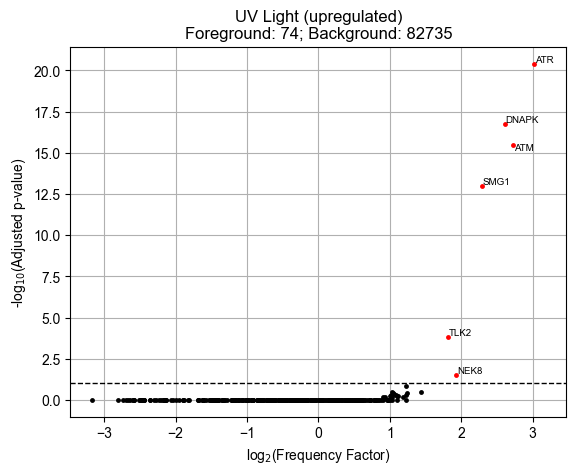

In [8]:
enrich_results.plot_volcano(title='UV Light (upregulated)')

As expected, the DNA-damage kinases (ATM, ATR, DNAPK, SMG1) are the most enriched motifs in the list of sites connected to UV light.

A custom background can be used as well, for example:


Calculating percentiles for foreground data
Scoring 74 ser_thr substrates
Calculating percentile for 74 ser_thr substrates


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:02<00:00, 106.64it/s]



Calculating percentiles for background data
Scoring 58113 ser_thr substrates
Calculating percentile for 58113 ser_thr substrates


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:06<00:00, 47.32it/s]


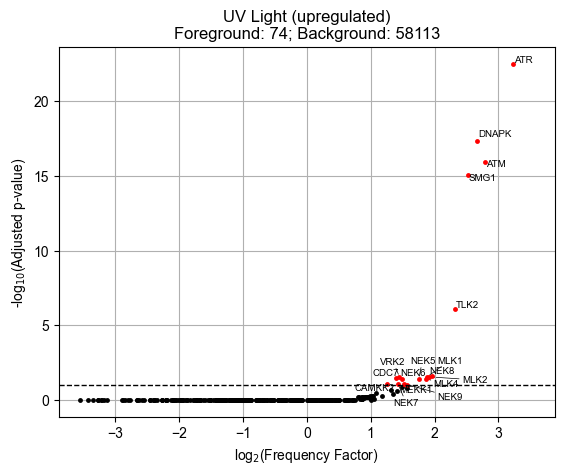

In [9]:
enrich_data = kl.EnrichmentData(foreground=fg_subs, background=phospho_signatures, fg_seq_col='site.flanking', bg_seq_col='site.flanking', suppress_warnings=True)

kin_type = 'ser_thr'
method = 'percentile_rank'
thresh = 15

enrich_results = enrich_data.kinase_enrichment(kin_type=kin_type, kl_method=method, kl_thresh=thresh)

enrich_results.plot_volcano(title='UV Light (upregulated)')

The binary enrichment analysis uses **one-sided** Fisher's exact test as a default, as the hypothesis tested is whether a kinase is **more often** predicted among substrates in the foreground list compared to the background list. As such, the volcano plot is **one-tailed**, since very negative log2(FF) (indicating depleted kinases) gets high (non-significant) p-value.

Nevertheless, if one wants to compare two separate list and test for enrichment of kinases in either one of the lists compared to the other, they can use two-sided test by setting `enrichment_type` to be `'both'`:


Calculating percentiles for foreground data
Scoring 79 ser_thr substrates
Calculating percentile for 79 ser_thr substrates


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:02<00:00, 119.18it/s]



Calculating percentiles for background data
Scoring 54 ser_thr substrates
Calculating percentile for 54 ser_thr substrates


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:02<00:00, 109.98it/s]


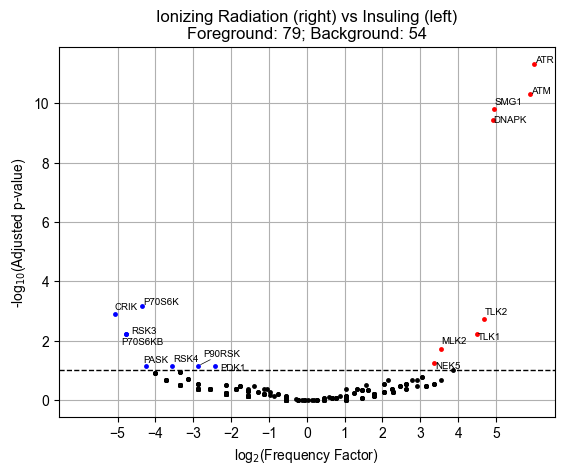

In [10]:
pathway_a = 'PERT-PSP_IONIZING_RADIATION' #Phosphosites associated with ionizing radiation
pathway_b = 'PERT-PSP_INSULIN' #Phosphosites associated with insulin
direction = 'u' #Upregulated phosphosites

fg_subs = phospho_signatures[(phospho_signatures['signature'] == pathway_a) & (phospho_signatures['site.direction'] == direction)]
bg_subs = phospho_signatures[(phospho_signatures['signature'] == pathway_b) & (phospho_signatures['site.direction'] == direction)]

enrich_data = kl.EnrichmentData(foreground=fg_subs, background=bg_subs, fg_seq_col='site.flanking', bg_seq_col='site.flanking', suppress_warnings=True)

kin_type = 'ser_thr'
method = 'percentile_rank'
thresh = 15

enrich_results = enrich_data.kinase_enrichment(kin_type=kin_type, kl_method=method, kl_thresh=thresh, enrichment_type='both')

enrich_results.plot_volcano(title='Ionizing Radiation (right) vs Insuling (left)')

In case of running multiple enrichment analyses from the same dataset, you can first score the database one time and then submit the scores in each run instead of re-calculating the scores each run (_note that for tyrosine kinase enrichment we use nominal p-value with signifiance threshold of 0.05_):

31 entries were omitted due to invalid amino acids or characters.
205 entries were omitted due to invalid central phosphoacceptor.
Use the 'omited_entries' attribute to view dropped enteries due to invalid sequences.
Scoring 9190 tyrosine substrates
Calculating percentile for 9190 tyrosine substrates


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 497.90it/s]


Scoring 5431 tyrosine substrates
Calculating percentile for 5431 tyrosine substrates


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:00<00:00, 744.08it/s]


Pathway: KINASE-PSP_Fyn/FYN; Direction: u


Percentiles submitted successfully.
Percentiles submitted successfully.

Pathway: KINASE-iKiP_INSR; Direction: u
Percentiles submitted successfully.
Percentiles submitted successfully.

Pathway: PERT-PSP_ERLOTINIB; Direction: d
Percentiles submitted successfully.
Percentiles submitted successfully.


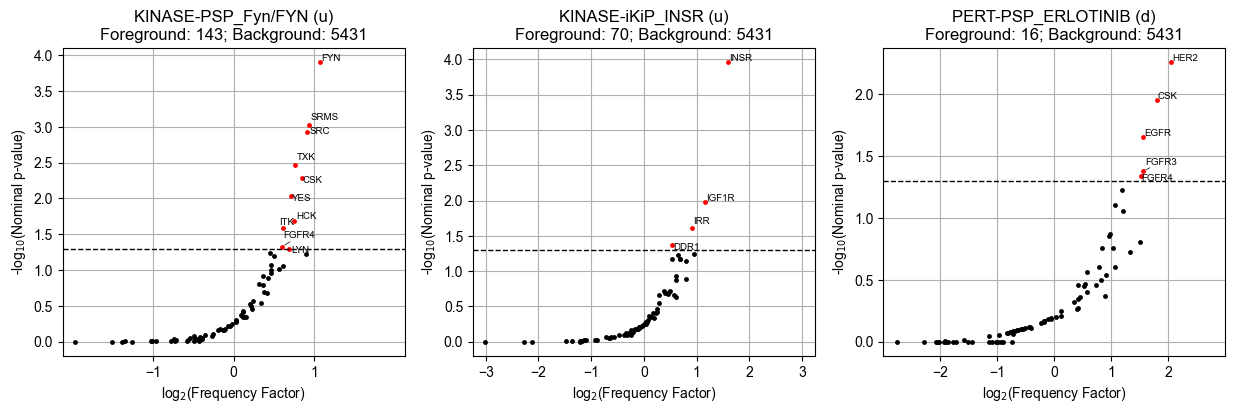

In [11]:
# Calculating scores and percentiles for the foreground data
phos_sig_pps = kl.PhosphoProteomics(phospho_signatures, seq_col='site.flanking')
phos_sig_tyr_scores = phos_sig_pps.score(kin_type='tyrosine', values_only=True) #In case scores or score-ranks are used for the enrichment analysis
phos_sig_tyr_percentiles = phos_sig_pps.percentile(kin_type='tyrosine', values_only=True)

# Calculating scores and percentiles for the background data (in this case - the KL phosphoproteome)
kl_phosprot = kl.get_phosphoproteome(kin_type='tyrosine')
kl_phosprot_pps = kl.PhosphoProteomics(kl_phosprot)
kl_phosprot_tyr_percentiles = kl_phosprot_pps.percentile(kin_type='tyrosine', values_only=True)

kin_type = 'tyrosine'
method = 'percentile_rank'
thresh = 8

fig,ax = plt.subplots(1,3,figsize=(15,4))

for i,(path,direction) in enumerate(zip(['KINASE-PSP_Fyn/FYN','KINASE-iKiP_INSR','PERT-PSP_ERLOTINIB'],['u','u','d'])):
    print(f'\nPathway: {path}; Direction: {direction}')
    
    fg_subs = phospho_signatures[(phospho_signatures['signature'] == path) & (phospho_signatures['site.direction'] == direction)]
    
    enrich_data = kl.EnrichmentData(foreground=fg_subs, fg_seq_col='site.flanking', suppress_warnings=True)
    #enrich_data.submit_scores(kin_type='tyrosine', scores=phos_sig_tyr_scores, data_type='fg') #In case scores or score-ranks are used for the enrichment analysis
    enrich_data.submit_percentiles(kin_type='tyrosine', percentiles=phos_sig_tyr_percentiles, data_type='fg')
    enrich_data.submit_percentiles(kin_type='tyrosine', percentiles=kl_phosprot_tyr_percentiles, data_type='bg')
    
    enrich_results = enrich_data.kinase_enrichment(kin_type=kin_type, kl_method=method, kl_thresh=thresh)
    
    enrich_results.plot_volcano(title=f'{path} ({direction})', adj_pval=False, sig_pval=0.05, ax=ax[i])

### Downstream substrates

Finally, further analysis of the enriched kinases can be used to derive a list of putative downstream substrates, most of which were never reported or even studied. For example, phorbol esters are known to activate PKC:


Calculating percentiles for foreground data
Scoring 103 ser_thr substrates
Calculating percentile for 103 ser_thr substrates


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:02<00:00, 115.09it/s]



Calculating percentiles for background data
Scoring 82735 ser_thr substrates
Calculating percentile for 82735 ser_thr substrates


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:08<00:00, 37.60it/s]


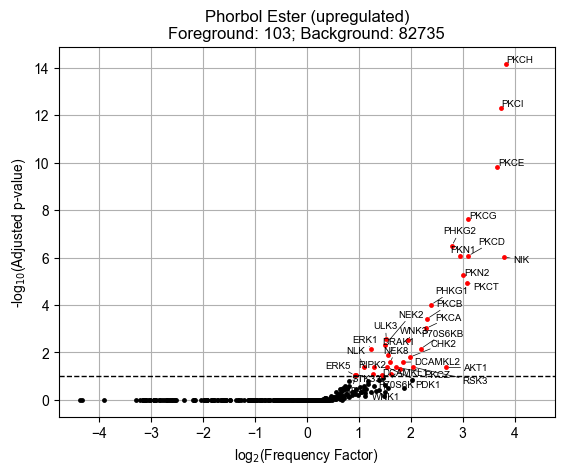

In [12]:
pathway = 'PERT-PSP_PHORBOL_ESTER'
direction = 'u'

fg_subs = phospho_signatures[(phospho_signatures['signature'] == pathway) & (phospho_signatures['site.direction'] == direction)]

enrich_data = kl.EnrichmentData(foreground=fg_subs, fg_seq_col='site.flanking', suppress_warnings=True)

kin_type = 'ser_thr'
method = 'percentile_rank'
thresh = 15

enrich_results = enrich_data.kinase_enrichment(kin_type=kin_type, kl_method=method, kl_thresh=thresh)

enrich_results.plot_volcano(title='Phorbol Ester (upregulated)')

In [13]:
enrich_results.enriched_kins()

['AKT1',
 'CHK2',
 'DCAMKL1',
 'DCAMKL2',
 'DRAK1',
 'ERK1',
 'ERK5',
 'NEK2',
 'NEK8',
 'NIK',
 'NLK',
 'P38A',
 'P70S6K',
 'P70S6KB',
 'PDK1',
 'PHKG1',
 'PHKG2',
 'PKCA',
 'PKCB',
 'PKCD',
 'PKCE',
 'PKCG',
 'PKCH',
 'PKCI',
 'PKCT',
 'PKCZ',
 'PKN1',
 'PKN2',
 'RIPK2',
 'RSK3',
 'STK33',
 'ULK3',
 'WNK1',
 'WNK3']

Now you can explore the downstream substrates that led to the enrichment of different PKCs, among which are potentially novel downstream targets of these kinases:

In [14]:
enrich_results.enriched_subs(kinases='PKCE')

{'PKCE':                               signature  category  site.uniprot  \
 Sequence                                                          
 RSSIRRLsTRRR___  PERT-PSP_PHORBOL_ESTER  PERT-PSP    O00168;S88   
 KKKKKRFsFKKSFKL  PERT-PSP_PHORBOL_ESTER  PERT-PSP   P29966;S159   
 GQKFARKsTRRSIRL  PERT-PSP_PHORBOL_ESTER  PERT-PSP   P08567;S113   
 KKKFRTPsFLKKSKK  PERT-PSP_PHORBOL_ESTER  PERT-PSP   P35612;S713   
 KKKFRTPsFLKKSKK  PERT-PSP_PHORBOL_ESTER  PERT-PSP   P35611;S726   
 GAPPRRSsIRNAHSI  PERT-PSP_PHORBOL_ESTER  PERT-PSP   P14598;S304   
 GVRQSRAsDKQTLLP  PERT-PSP_PHORBOL_ESTER  PERT-PSP   P09693;S148   
 AHSIHQRsRKRLSQD  PERT-PSP_PHORBOL_ESTER  PERT-PSP   P14598;S315   
 EEGTFRSsIRRLSTR  PERT-PSP_PHORBOL_ESTER  PERT-PSP    O00168;S83   
 AKRRRLSsLRASTSK  PERT-PSP_PHORBOL_ESTER  PERT-PSP   P62753;S236   
 RHIVRKRtLRRLLQE  PERT-PSP_PHORBOL_ESTER  PERT-PSP   P00533;T678   
 DKMKKSKsVKEDSNL  PERT-PSP_PHORBOL_ESTER  PERT-PSP  P46940;S1443   
 DTATKSGsTTKNRFV  PERT-PSP_PHORBOL_ESTER

Or it can be saved to an excel file by setting `save_to_excel` to be True, and specifying `output_dir` (multiple kinases can be analyzed at once, each wil appear in a different sheet):

In [ ]:
enrich_results.enriched_subs(kinases=['PKCE','PKCH','PKCI'], save_to_excel=True, output_dir='/Users/usr/Desktop/', file_prefix='Phorbol Ester subs')